<a href="https://colab.research.google.com/github/ehsankarami1358/UPKA_HYDRO/blob/main/UPKA_Hill_chart_u2_r1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, RBFInterpolator
from scipy.ndimage import gaussian_filter
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# ============================================
# PART 1: DATA PROCESSING FOR YOUR SPECIFIC CSV
# ============================================

class HillChartAnalyzer:
    def __init__(self, runner_diameter=4.2, design_head=90.5):  # You need to set these!
        """
        runner_diameter: Your turbine runner diameter in meters
        design_head: Design head for your plant (for reference)
        """
        self.D = runner_diameter
        self.design_head = design_head

    def load_and_preprocess(self, filepath):
        """Load your specific CSV file and preprocess"""
        # Load data
        df = pd.read_csv(filepath)

        # Convert timestamp
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Date'] = df['Timestamp'].dt.date
        df['Hour'] = df['Timestamp'].dt.hour

        # Calculate Net Head (Gross Head)
        df['Net_Head'] = df['HEAD_L(m)'] - df['TAIL_L(m)']

        # Rename columns to match expected names
        df.rename(columns={
            'ACTIVE_POWER(MW)': 'Active_Power',
            'OPPENING(%)': 'GVO',
            'FLOW(m3/s)': 'Flow'
        }, inplace=True)

        # Filter out shutdown periods (near-zero power)
        df = df[df['Active_Power'] > 1.0]  # Remove shutdown/startup

        # Calculate efficiency (assuming generator efficiency ~ 98%)
        # η = (Electrical Power) / (Hydraulic Power)
        # Hydraulic Power = ρ * g * Q * H / 1000 [kW]
        # where ρ = 1000 kg/m³, g = 9.81 m/s²
        df['Hydraulic_Power'] = 1000 * 9.81 * df['Flow'] * df['Net_Head'] / 1000000  # MW
        df['Efficiency'] = df['Active_Power'] / df['Hydraulic_Power']

        # Filter reasonable efficiency values
        df = df[(df['Efficiency'] > 0.7) & (df['Efficiency'] < 0.96)]

        return df

    def calculate_unit_parameters(self, df):
        """Calculate normalized unit parameters"""
        df = df.copy()

        # Unit parameters (n11, Q11, P11)
        df['sqrt_H'] = np.sqrt(df['Net_Head'])
        df['H_32'] = df['Net_Head'] ** 1.5

        # If you know runner diameter and speed
        # n11 = (N * D) / √H
        # But we don't have N (RPM), so we'll use relative unit speed

        # For relative comparison, we can use:
        # n11_rel = 1/√H (since N is constant for fixed-speed turbine)
        df['n11_rel'] = 1 / df['sqrt_H']

        # Unit discharge: Q11 = Q / (D² * √H)
        if self.D:
            df['Q11'] = df['Flow'] / (self.D**2 * df['sqrt_H'])
        else:
            # Relative Q11 if D unknown
            df['Q11'] = df['Flow'] / df['sqrt_H']

        # Unit power: P11 = P / (D² * H^(3/2))
        if self.D:
            df['P11'] = df['Active_Power'] / (self.D**2 * df['H_32'])
        else:
            # Relative P11
            df['P11'] = df['Active_Power'] / df['H_32']

        return df

    def prepare_steady_state_data(self, df, window_minutes=10):
        """Identify steady-state operating periods"""
        # Resample to consistent intervals if needed
        df.set_index('Timestamp', inplace=True)
        df_resampled = df.resample('5min').mean().reset_index()

        # Calculate rolling statistics for steady-state detection
        df_resampled['power_std'] = df_resampled['Active_Power'].rolling(window=3).std()
        df_resampled['head_std'] = df_resampled['Net_Head'].rolling(window=3).std()
        df_resampled['flow_std'] = df_resampled['Flow'].rolling(window=3).std()

        # Define steady-state conditions
        power_threshold = df_resampled['Active_Power'].mean() * 0.02  # 2% variation
        head_threshold = df_resampled['Net_Head'].mean() * 0.005     # 0.5% variation

        steady_mask = (
            (df_resampled['power_std'] < power_threshold) &
            (df_resampled['head_std'] < head_threshold) &
            (df_resampled['Active_Power'] > 5)  # Minimum power
        )

        df_steady = df_resampled[steady_mask].copy()

        # Also filter by operating hours (remove maintenance periods)
        # Keep normal operating hours (e.g., 6 AM to 10 PM)
        df_steady['Hour'] = df_steady['Timestamp'].dt.hour
        df_steady = df_steady[(df_steady['Hour'] >= 6) & (df_steady['Hour'] <= 22)]

        return df_steady

# ============================================
# PART 2: HILL CHART RECONSTRUCTION
# ============================================

class HillChartReconstructor:
    def reconstruct_hill_chart(self, df, method='linear', grid_size=50):
        """
        Reconstruct Hill Chart from operational data

        Parameters:
        -----------
        df: DataFrame with 'n11_rel', 'Q11', 'Efficiency' columns
        method: Interpolation method ('linear', 'cubic', 'rbf')
        grid_size: Number of grid points in each dimension
        """
        # Filter valid data
        valid_data = df.dropna(subset=['n11_rel', 'Q11', 'Efficiency'])

        if len(valid_data) < 10:
            print("Warning: Not enough data points for reconstruction")
            return None, None, None

        # Create grid
        n11_min, n11_max = valid_data['n11_rel'].min(), valid_data['n11_rel'].max()
        q11_min, q11_max = valid_data['Q11'].min(), valid_data['Q11'].max()

        # Add some padding
        n11_range = n11_max - n11_min
        q11_range = q11_max - q11_min
        n11_min -= 0.1 * n11_range
        n11_max += 0.1 * n11_range
        q11_min -= 0.1 * q11_range
        q11_max += 0.1 * q11_range

        # Create meshgrid
        n11_grid = np.linspace(n11_min, n11_max, grid_size)
        q11_grid = np.linspace(q11_min, q11_max, grid_size)
        n11_mesh, q11_mesh = np.meshgrid(n11_grid, q11_grid)

        # Prepare source points
        points = valid_data[['n11_rel', 'Q11']].values
        values = valid_data['Efficiency'].values

        if method == 'rbf':
            # RBF interpolation
            rbf = RBFInterpolator(points, values, kernel='thin_plate', smoothing=0.1)
            grid_points = np.column_stack([n11_mesh.ravel(), q11_mesh.ravel()])
            efficiency_grid = rbf(grid_points).reshape(n11_mesh.shape)
        else:
            # Griddata interpolation
            efficiency_grid = griddata(
                points, values,
                (n11_mesh, q11_mesh),
                method=method,
                fill_value=np.nan
            )

        # Smooth the result
        if not np.all(np.isnan(efficiency_grid)):
            efficiency_grid = gaussian_filter(efficiency_grid, sigma=1.0)

        return n11_mesh, q11_mesh, efficiency_grid

    def detect_operating_regimes(self, df, eps=0.15, min_samples=5):
        """Cluster operating points into different regimes"""
        features = df[['n11_rel', 'Q11', 'GVO']].copy()

        # Scale features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples)
        df['Cluster'] = clustering.fit_predict(features_scaled)

        # Calculate statistics per cluster
        cluster_stats = df.groupby('Cluster').agg({
            'Efficiency': ['mean', 'std', 'count'],
            'n11_rel': 'mean',
            'Q11': 'mean',
            'GVO': 'mean',
            'Active_Power': 'mean',
            'Net_Head': 'mean'
        }).round(4)

        return df, cluster_stats

    def calculate_performance_metrics(self, df, df_original=None):
        """Calculate key performance metrics"""
        metrics = {}

        # 1. Average efficiency
        metrics['avg_efficiency'] = df['Efficiency'].mean()

        # 2. Efficiency at different GVO ranges
        gvo_bins = [0, 50, 70, 85, 95, 100]
        gvo_labels = ['<50%', '50-70%', '70-85%', '85-95%', '>95%']
        df['GVO_bin'] = pd.cut(df['GVO'], bins=gvo_bins, labels=gvo_labels)

        gvo_efficiency = df.groupby('GVO_bin')['Efficiency'].agg(['mean', 'std', 'count'])
        metrics['gvo_efficiency'] = gvo_efficiency

        # 3. Specific energy (kWh per m³ of water)
        df['Specific_Energy'] = df['Active_Power'] * 1000 / df['Flow']  # kWh/m³
        metrics['avg_specific_energy'] = df['Specific_Energy'].mean()

        # 4. Best Efficiency Point (BEP)
        bep_idx = df['Efficiency'].idxmax()
        metrics['BEP'] = {
            'Efficiency': df.loc[bep_idx, 'Efficiency'],
            'n11_rel': df.loc[bep_idx, 'n11_rel'],
            'Q11': df.loc[bep_idx, 'Q11'],
            'GVO': df.loc[bep_idx, 'GVO'],
            'Power': df.loc[bep_idx, 'Active_Power'],
            'Head': df.loc[bep_idx, 'Net_Head']
        }

        # 5. Compare with original if provided
        if df_original is not None:
            original_bep_idx = df_original['Efficiency'].idxmax()
            metrics['Original_BEP'] = {
                'Efficiency': df_original.loc[original_bep_idx, 'Efficiency'],
                'n11_rel': df_original.loc[original_bep_idx, 'n11_rel'],
                'Q11': df_original.loc[original_bep_idx, 'Q11']
            }
            metrics['Efficiency_loss'] = (
                metrics['Original_BEP']['Efficiency'] - metrics['BEP']['Efficiency']
            ) * 100

        return metrics

# ============================================
# PART 3: VISUALIZATION
# ============================================

class HillChartVisualizer:
    @staticmethod
    def plot_hill_chart_comparison(df, n11_mesh, q11_mesh, efficiency_grid):
        """Create comprehensive Hill Chart visualization"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Scatter plot of actual data (colored by efficiency)
        scatter1 = axes[0, 0].scatter(
            df['n11_rel'], df['Q11'],
            c=df['Efficiency'],
            s=30, alpha=0.6, cmap='viridis',
            vmin=0.85, vmax=0.94
        )
        axes[0, 0].set_xlabel('Relative Unit Speed (n11_rel)')
        axes[0, 0].set_ylabel('Unit Discharge (Q11)')
        axes[0, 0].set_title('Actual Operating Points (Colored by Efficiency)')
        plt.colorbar(scatter1, ax=axes[0, 0], label='Efficiency')

        # 2. Contour plot of reconstructed Hill Chart
        if efficiency_grid is not None and not np.all(np.isnan(efficiency_grid)):
            contour = axes[0, 1].contourf(
                n11_mesh, q11_mesh, efficiency_grid,
                levels=20, cmap='viridis', alpha=0.8
            )
            axes[0, 1].scatter(
                df['n11_rel'], df['Q11'],
                c='red', s=10, alpha=0.3, label='Actual Points'
            )
            axes[0, 1].set_xlabel('Relative Unit Speed (n11_rel)')
            axes[0, 1].set_title('Reconstructed Hill Chart')
            plt.colorbar(contour, ax=axes[0, 1], label='Efficiency')
            axes[0, 1].legend()

        # 3. Efficiency vs Guide Vane Opening
        axes[0, 2].scatter(df['GVO'], df['Efficiency'], alpha=0.5)
        axes[0, 2].set_xlabel('Guide Vane Opening (%)')
        axes[0, 2].set_ylabel('Efficiency')
        axes[0, 2].set_title('Efficiency vs Guide Vane Opening')
        axes[0, 2].grid(True, alpha=0.3)

        # 4. Power-Flow characteristic
        axes[1, 0].scatter(df['Flow'], df['Active_Power'], c=df['Net_Head'], alpha=0.6)
        axes[1, 0].set_xlabel('Flow (m³/s)')
        axes[1, 0].set_ylabel('Active Power (MW)')
        axes[1, 0].set_title('Power-Flow Characteristic (Colored by Head)')

        # 5. Efficiency histogram
        axes[1, 1].hist(df['Efficiency'], bins=30, edgecolor='black', alpha=0.7)
        axes[1, 1].set_xlabel('Efficiency')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Efficiency Distribution')
        axes[1, 1].axvline(df['Efficiency'].mean(), color='red', linestyle='--',
                          label=f'Mean: {df["Efficiency"].mean():.3f}')
        axes[1, 1].legend()

        # 6. Time series of efficiency
        if 'Timestamp' in df.columns:
            df_sorted = df.sort_values('Timestamp')
            axes[1, 2].plot(df_sorted['Timestamp'], df_sorted['Efficiency'],
                           alpha=0.7, linewidth=1)
            axes[1, 2].set_xlabel('Time')
            axes[1, 2].set_ylabel('Efficiency')
            axes[1, 2].set_title('Efficiency Trend Over Time')
            axes[1, 2].tick_params(axis='x', rotation=45)
            axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    @staticmethod
    def plot_performance_degradation(df_monthly):
        """Plot performance degradation over time"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Calculate monthly statistics
        if 'Timestamp' in df_monthly.columns:
            df_monthly['Month'] = df_monthly['Timestamp'].dt.to_period('M')
            monthly_stats = df_monthly.groupby('Month').agg({
                'Efficiency': ['mean', 'std', 'max'],
                'Specific_Energy': 'mean',
                'Active_Power': 'mean'
            }).round(4)

            # 1. Monthly average efficiency
            axes[0, 0].errorbar(
                range(len(monthly_stats)),
                monthly_stats[('Efficiency', 'mean')],
                yerr=monthly_stats[('Efficiency', 'std')],
                fmt='o-', capsize=5
            )
            axes[0, 0].set_xlabel('Month')
            axes[0, 0].set_ylabel('Efficiency')
            axes[0, 0].set_title('Monthly Average Efficiency')
            axes[0, 0].grid(True, alpha=0.3)

            # 2. Peak efficiency trend
            axes[0, 1].plot(
                range(len(monthly_stats)),
                monthly_stats[('Efficiency', 'max')],
                'o-', color='red'
            )
            axes[0, 1].set_xlabel('Month')
            axes[0, 1].set_ylabel('Peak Efficiency')
            axes[0, 1].set_title('Peak Efficiency Trend')
            axes[0, 1].grid(True, alpha=0.3)

            # 3. Specific energy trend
            axes[1, 0].plot(
                range(len(monthly_stats)),
                monthly_stats[('Specific_Energy', 'mean')],
                'o-', color='green'
            )
            axes[1, 0].set_xlabel('Month')
            axes[1, 0].set_ylabel('Specific Energy (kWh/m³)')
            axes[1, 0].set_title('Water-to-Energy Conversion Efficiency')
            axes[1, 0].grid(True, alpha=0.3)

            # 4. Operating hours at different efficiency ranges
            efficiency_bins = [0.85, 0.88, 0.91, 0.94, 1.0]
            df_monthly['Efficiency_bin'] = pd.cut(
                df_monthly['Efficiency'], bins=efficiency_bins
            )

            monthly_efficiency_dist = pd.crosstab(
                df_monthly['Month'],
                df_monthly['Efficiency_bin']
            )

            monthly_efficiency_dist.plot(kind='bar', stacked=True, ax=axes[1, 1])
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel('Number of Operating Points')
            axes[1, 1].set_title('Efficiency Distribution by Month')
            axes[1, 1].legend(title='Efficiency Range')
            axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        return fig

# ============================================
# PART 4: MAIN ANALYSIS WORKFLOW
# ============================================

def run_complete_analysis(filepath, runner_diameter=None):
    """Complete workflow for analyzing hydropower unit performance"""

    print("="*60)
    print("HYDROPOWER TURBINE PERFORMANCE ANALYSIS")
    print("="*60)

    # Step 1: Initialize analyzer
    analyzer = HillChartAnalyzer(runner_diameter=runner_diameter)

    # Step 2: Load and preprocess data
    print("\n1. Loading and preprocessing data...")
    df_raw = analyzer.load_and_preprocess(filepath)
    print(f"   Loaded {len(df_raw)} data points")
    print(f"   Date range: {df_raw['Timestamp'].min()} to {df_raw['Timestamp'].max()}")
    print(f"   Average head: {df_raw['Net_Head'].mean():.2f} m")
    print(f"   Average power: {df_raw['Active_Power'].mean():.2f} MW")

    # Step 3: Calculate unit parameters
    print("\n2. Calculating unit parameters...")
    df_with_params = analyzer.calculate_unit_parameters(df_raw)

    # Step 4: Prepare steady-state data
    print("\n3. Identifying steady-state operating points...")
    df_steady = analyzer.prepare_steady_state_data(df_with_params)
    print(f"   Found {len(df_steady)} steady-state points")

    if len(df_steady) < 20:
        print("   Warning: Limited steady-state data available")
        print("   Consider adjusting steady-state detection parameters")

    # Step 5: Reconstruct Hill Chart
    print("\n4. Reconstructing Hill Chart...")
    reconstructor = HillChartReconstructor()
    n11_mesh, q11_mesh, efficiency_grid = reconstructor.reconstruct_hill_chart(df_steady)

    # Step 6: Detect operating regimes
    print("\n5. Detecting operating regimes...")
    df_clustered, cluster_stats = reconstructor.detect_operating_regimes(df_steady)
    print(f"   Detected {len(cluster_stats)} operating regimes")

    # Step 7: Calculate performance metrics
    print("\n6. Calculating performance metrics...")
    metrics = reconstructor.calculate_performance_metrics(df_clustered)

    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Average Efficiency: {metrics['avg_efficiency']:.4f}")
    print(f"Best Efficiency Point: {metrics['BEP']['Efficiency']:.4f}")
    print(f"  - at GVO: {metrics['BEP']['GVO']:.1f}%")
    print(f"  - at Power: {metrics['BEP']['Power']:.2f} MW")
    print(f"  - at Head: {metrics['BEP']['Head']:.2f} m")
    print(f"Specific Energy: {metrics['avg_specific_energy']:.2f} kWh/m³")

    # Display GVO efficiency table
    print("\nEfficiency by Guide Vane Opening Range:")
    print("-"*50)
    print(metrics['gvo_efficiency'].round(4))

    # Display cluster statistics
    print("\nOperating Regimes:")
    print("-"*50)
    print(cluster_stats.round(4))

    # Step 8: Create visualizations
    print("\n7. Generating visualizations...")
    visualizer = HillChartVisualizer()

    # Create Hill Chart comparison
    fig1 = visualizer.plot_hill_chart_comparison(
        df_clustered, n11_mesh, q11_mesh, efficiency_grid
    )

    # Create performance degradation plot
    fig2 = visualizer.plot_performance_degradation(df_clustered)

    # Additional specialized plots
    fig3, axes3 = plt.subplots(1, 2, figsize=(14, 6))

    # Flow vs Power at different heads
    for head_range in np.percentile(df_clustered['Net_Head'], [25, 50, 75]):
        head_data = df_clustered[
            np.abs(df_clustered['Net_Head'] - head_range) < 2
        ]
        if len(head_data) > 0:
            axes3[0].scatter(
                head_data['Flow'], head_data['Active_Power'],
                alpha=0.5, label=f'Head ~ {head_range:.1f} m'
            )
    axes3[0].set_xlabel('Flow (m³/s)')
    axes3[0].set_ylabel('Active Power (MW)')
    axes3[0].set_title('Power-Flow at Different Heads')
    axes3[0].legend()
    axes3[0].grid(True, alpha=0.3)

    # Efficiency vs Specific Energy
    scatter3 = axes3[1].scatter(
        df_clustered['Efficiency'], df_clustered['Specific_Energy'],
        c=df_clustered['Net_Head'], alpha=0.6, cmap='coolwarm'
    )
    axes3[1].set_xlabel('Efficiency')
    axes3[1].set_ylabel('Specific Energy (kWh/m³)')
    axes3[1].set_title('Efficiency vs Specific Energy (Colored by Head)')
    plt.colorbar(scatter3, ax=axes3[1], label='Net Head (m)')
    axes3[1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Step 9: Generate recommendations
    print("\n" + "="*60)
    print("RECOMMENDATIONS & INSIGHTS")
    print("="*60)

    # Analyze efficiency by GVO range
    best_gvo_range = metrics['gvo_efficiency']['mean'].idxmax()
    best_efficiency = metrics['gvo_efficiency']['mean'].max()
    worst_gvo_range = metrics['gvo_efficiency']['mean'].idxmin()
    worst_efficiency = metrics['gvo_efficiency']['mean'].min()

    print(f"\n1. Optimal Operating Range:")
    print(f"   Best efficiency ({best_efficiency:.4f}) at GVO range: {best_gvo_range}")
    print(f"   Worst efficiency ({worst_efficiency:.4f}) at GVO range: {worst_gvo_range}")

    # Check for efficiency degradation patterns
    if 'Efficiency_loss' in metrics:
        loss_percent = metrics['Efficiency_loss']
        if loss_percent > 2:
            print(f"\n2. Significant Efficiency Loss Detected:")
            print(f"   Estimated loss: {loss_percent:.2f}% from original")
            print(f"   Possible causes: Runner wear, increased clearances")
            print(f"   Recommendation: Schedule turbine inspection")

    # Analyze operating regime distribution
    most_common_cluster = cluster_stats[('Efficiency', 'count')].idxmax()
    cluster_count = cluster_stats.loc[most_common_cluster, ('Efficiency', 'count')]
    total_points = cluster_stats[('Efficiency', 'count')].sum()

    if cluster_count / total_points > 0.7:
        print(f"\n3. Limited Operating Range:")
        print(f"   {cluster_count/total_points*100:.1f}% of operation in one regime")
        print(f"   This limits Hill Chart reconstruction accuracy")
        print(f"   Consider varying operating conditions for better assessment")

    # Check for data quality issues
    if len(df_steady) < 50:
        print(f"\n4. Data Quality Concern:")
        print(f"   Only {len(df_steady)} steady-state points available")
        print(f"   Need more data for reliable performance assessment")
        print(f"   Collect data during varied operating conditions")

    print(f"\n5. Maintenance Indicators:")
    print(f"   Monitor efficiency at {worst_gvo_range} GVO range")
    print(f"   Track specific energy trend for degradation")
    print(f"   Best operation at: {best_gvo_range} GVO, {metrics['BEP']['Power']:.1f} MW")

    # Return all results
    results = {
        'raw_data': df_raw,
        'steady_data': df_steady,
        'clustered_data': df_clustered,
        'hill_chart': (n11_mesh, q11_mesh, efficiency_grid),
        'cluster_stats': cluster_stats,
        'performance_metrics': metrics,
        'visualizations': {
            'hill_chart_comparison': fig1,
            'performance_trends': fig2,
            'additional_analysis': fig3
        }
    }

    return results

# ============================================
# PART 5: USAGE EXAMPLE
# ============================================

if __name__ == "__main__":
    # Configure these parameters for your specific turbine
    RUNNER_DIAMETER = 2  # Enter your turbine runner diameter in meters
    CSV_FILE_PATH = "Unit4_flow_mw_op_R1.csv"  # Your data file

    print("Starting analysis of Unit 4 performance data...")
    print(f"File: {CSV_FILE_PATH}")
    print(f"Assumed runner diameter: {RUNNER_DIAMETER} m")

    try:
        # Run complete analysis
        results = run_complete_analysis(CSV_FILE_PATH, runner_diameter=RUNNER_DIAMETER)

        # Save results
        print("\n" + "="*60)
        print("SAVING RESULTS")
        print("="*60)

        # Save data to Excel
        with pd.ExcelWriter('turbine_performance_analysis.xlsx') as writer:
            results['raw_data'].to_excel(writer, sheet_name='Raw_Data', index=False)
            results['steady_data'].to_excel(writer, sheet_name='Steady_State_Data', index=False)
            results['clustered_data'].to_excel(writer, sheet_name='Clustered_Data', index=False)
            results['cluster_stats'].to_excel(writer, sheet_name='Cluster_Statistics')

        print("✓ Data saved to 'turbine_performance_analysis.xlsx'")

        # Save figures
        results['visualizations']['hill_chart_comparison'].savefig(
            'hill_chart_comparison.png', dpi=300, bbox_inches='tight'
        )
        results['visualizations']['performance_trends'].savefig(
            'performance_trends.png', dpi=300, bbox_inches='tight'
        )
        results['visualizations']['additional_analysis'].savefig(
            'additional_analysis.png', dpi=300, bbox_inches='tight'
        )

        print("✓ Figures saved as PNG files")

        # Generate summary report
        with open('performance_summary.txt', 'w') as f:
            f.write("TURBINE PERFORMANCE ANALYSIS REPORT\n")
            f.write("="*50 + "\n\n")
            f.write(f"Analysis Date: {pd.Timestamp.now()}\n")
            f.write(f"Data File: {CSV_FILE_PATH}\n")
            f.write(f"Runner Diameter: {RUNNER_DIAMETER} m\n")
            f.write(f"Number of data points: {len(results['raw_data'])}\n")
            f.write(f"Steady-state points: {len(results['steady_data'])}\n")
            f.write(f"\nPERFORMANCE METRICS:\n")
            f.write(f"Average Efficiency: {results['performance_metrics']['avg_efficiency']:.4f}\n")
            f.write(f"Best Efficiency: {results['performance_metrics']['BEP']['Efficiency']:.4f}\n")
            f.write(f"Best Efficiency GVO: {results['performance_metrics']['BEP']['GVO']:.1f}%\n")
            f.write(f"Specific Energy: {results['performance_metrics']['avg_specific_energy']:.2f} kWh/m³\n")

        print("✓ Summary report saved to 'performance_summary.txt'")
        print("\nAnalysis completed successfully!")

        # Show plots
        plt.show()

    except Exception as e:
        print(f"\nError during analysis: {e}")
        import traceback
        traceback.print_exc()

Starting analysis of Unit 4 performance data...
File: Unit4_flow_mw_op_R1.csv
Assumed runner diameter: 2 m
HYDROPOWER TURBINE PERFORMANCE ANALYSIS

1. Loading and preprocessing data...

Error during analysis: [Errno 2] No such file or directory: 'Unit4_flow_mw_op_R1.csv'


Traceback (most recent call last):
  File "/tmp/ipython-input-225644495.py", line 587, in <cell line: 0>
    results = run_complete_analysis(CSV_FILE_PATH, runner_diameter=RUNNER_DIAMETER)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-225644495.py", line 411, in run_complete_analysis
    df_raw = analyzer.load_and_preprocess(filepath)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-225644495.py", line 28, in load_and_preprocess
    df = pd.read_csv(filepath)
         ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr

In [10]:
RUNNER_DIAMETER = 4.2  # Your actual runner diameter
CSV_FILE_PATH = "U2_processed_hydropower_data.csv"

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class WorkingPointAnalyzer:
    def __init__(self, filepath):
        """Initialize with your CSV file"""
        self.filepath = filepath
        self.df = None
        self.df_operational = None

    def load_and_preprocess(self):
        """Load and preprocess your specific CSV format"""
        # Load data
        self.df = pd.read_csv(self.filepath)

        # Convert timestamp
        self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp'])

        # Calculate Net Head
        self.df['Net_Head'] = self.df['HEAD_L(m)'] - self.df['TAIL_L(m)']

        # Rename for convenience
        self.df.rename(columns={
            'ACTIVE_POWER(MW)': 'Active_Power',
            'OPPENING(%)': 'Opening',
            'FLOW(m3/s)': 'Flow'
        }, inplace=True)

        # Calculate efficiency
        self.df['Efficiency'] = (self.df['Active_Power'] * 1000) / (9.81 * self.df['Flow'] * self.df['Net_Head'])

        # Filter for operational points (exclude shutdown/startup)
        self.df_operational = self.df[
            (self.df['Active_Power'] > 1.0) &
            (self.df['Flow'] > 1.0) &
            (self.df['Efficiency'] > 0.7) &
            (self.df['Efficiency'] < 0.96)
        ].copy()

        # Add time-based features
        self.df_operational['Hour'] = self.df_operational['Timestamp'].dt.hour
        self.df_operational['DayOfWeek'] = self.df_operational['Timestamp'].dt.dayofweek
        self.df_operational['Month'] = self.df_operational['Timestamp'].dt.month

        print(f"Total data points: {len(self.df)}")
        print(f"Operational points: {len(self.df_operational)}")
        print(f"Date range: {self.df['Timestamp'].min()} to {self.df['Timestamp'].max()}")

        return self.df_operational

    def calculate_statistics(self):
        """Calculate comprehensive statistics for all parameters"""
        stats_dict = {}

        parameters = ['Active_Power', 'Flow', 'Opening', 'Net_Head', 'Efficiency']

        for param in parameters:
            data = self.df_operational[param]
            stats_dict[param] = {
                'count': len(data),
                'mean': np.mean(data),
                'std': np.std(data),
                'min': np.min(data),
                '25%': np.percentile(data, 25),
                '50%': np.percentile(data, 50),
                '75%': np.percentile(data, 75),
                'max': np.max(data),
                'cv': np.std(data)/np.mean(data) if np.mean(data) != 0 else 0  # Coefficient of variation
            }

        # Calculate correlations
        corr_matrix = self.df_operational[['Active_Power', 'Flow', 'Opening', 'Net_Head', 'Efficiency']].corr()

        return pd.DataFrame(stats_dict).T, corr_matrix

    def plot_comprehensive_histograms(self):
        """Create comprehensive histogram plots"""
        fig = plt.figure(figsize=(20, 16))
        gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

        # 1. Active Power Histogram
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.hist(self.df_operational['Active_Power'], bins=30, edgecolor='black', alpha=0.7,
                color='skyblue', density=True)
        ax1.axvline(self.df_operational['Active_Power'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {self.df_operational["Active_Power"].mean():.2f} MW')
        ax1.axvline(self.df_operational['Active_Power'].median(), color='green', linestyle='--',
                   linewidth=2, label=f'Median: {self.df_operational["Active_Power"].median():.2f} MW')
        ax1.set_xlabel('Active Power (MW)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Frequency (Normalized)', fontsize=12)
        ax1.set_title('Active Power Distribution', fontsize=14, fontweight='bold', pad=15)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Add text box with statistics
        textstr = '\n'.join([
            f'Min: {self.df_operational["Active_Power"].min():.2f} MW',
            f'Max: {self.df_operational["Active_Power"].max():.2f} MW',
            f'Std: {self.df_operational["Active_Power"].std():.2f} MW',
            f'95% Range: [{np.percentile(self.df_operational["Active_Power"], 2.5):.1f}, ' \
            f'{np.percentile(self.df_operational["Active_Power"], 97.5):.1f}] MW'
        ])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

        # 2. Flow Histogram
        ax2 = fig.add_subplot(gs[0, 1])
        counts, bins, patches = ax2.hist(self.df_operational['Flow'], bins=30, edgecolor='black',
                                        alpha=0.7, color='lightgreen', density=True)
        ax2.axvline(self.df_operational['Flow'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {self.df_operational["Flow"].mean():.2f} m³/s')
        ax2.set_xlabel('Flow (m³/s)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Frequency (Normalized)', fontsize=12)
        ax2.set_title('Flow Distribution', fontsize=14, fontweight='bold', pad=15)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Opening Histogram
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.hist(self.df_operational['Opening'], bins=30, edgecolor='black', alpha=0.7,
                color='salmon', density=True)
        ax3.axvline(self.df_operational['Opening'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {self.df_operational["Opening"].mean():.2f}%')
        ax3.axvline(85, color='orange', linestyle=':', linewidth=2,
                   label='85% (Typical Optimal)')
        ax3.set_xlabel('Guide Vane Opening (%)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Frequency (Normalized)', fontsize=12)
        ax3.set_title('Guide Vane Opening Distribution', fontsize=14, fontweight='bold', pad=15)
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Net Head Histogram
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.hist(self.df_operational['Net_Head'], bins=30, edgecolor='black', alpha=0.7,
                color='gold', density=True)
        ax4.axvline(self.df_operational['Net_Head'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {self.df_operational["Net_Head"].mean():.2f} m')
        ax4.set_xlabel('Net Head (m)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Frequency (Normalized)', fontsize=12)
        ax4.set_title('Net Head Distribution', fontsize=14, fontweight='bold', pad=15)
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # 5. Efficiency Histogram
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.hist(self.df_operational['Efficiency'], bins=30, edgecolor='black', alpha=0.7,
                color='violet', density=True)
        ax5.axvline(self.df_operational['Efficiency'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {self.df_operational["Efficiency"].mean():.3f}')
        ax5.axvline(self.df_operational['Efficiency'].max(), color='green', linestyle=':',
                   linewidth=2, label=f'Max: {self.df_operational["Efficiency"].max():.3f}')
        ax5.set_xlabel('Efficiency', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Frequency (Normalized)', fontsize=12)
        ax5.set_title('Efficiency Distribution', fontsize=14, fontweight='bold', pad=15)
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # 6. Active Power vs Flow (Hexbin)
        ax6 = fig.add_subplot(gs[1, 2])
        hb = ax6.hexbin(self.df_operational['Flow'], self.df_operational['Active_Power'],
                       gridsize=30, cmap='Blues', mincnt=1)
        ax6.set_xlabel('Flow (m³/s)', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Active Power (MW)', fontsize=12, fontweight='bold')
        ax6.set_title('Power-Flow Relationship (Density)', fontsize=14, fontweight='bold', pad=15)
        cb = fig.colorbar(hb, ax=ax6)
        cb.set_label('Count', fontsize=10)

        # Add trend line
        z = np.polyfit(self.df_operational['Flow'], self.df_operational['Active_Power'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(self.df_operational['Flow'].min(), self.df_operational['Flow'].max(), 100)
        ax6.plot(x_range, p(x_range), 'r--', linewidth=2,
                label=f'Slope: {z[0]:.3f} MW/(m³/s)')
        ax6.legend()

        # 7. Efficiency vs Opening (Boxplot by Opening ranges)
        ax7 = fig.add_subplot(gs[2, 0])

        # Create opening bins
        self.df_operational['Opening_Bin'] = pd.cut(self.df_operational['Opening'],
                                                   bins=[0, 50, 70, 85, 95, 100],
                                                   labels=['<50%', '50-70%', '70-85%', '85-95%', '>95%'])

        # Boxplot
        box_data = []
        labels = []
        for bin_name in ['<50%', '50-70%', '70-85%', '85-95%', '>95%']:
            bin_data = self.df_operational[self.df_operational['Opening_Bin'] == bin_name]['Efficiency']
            if len(bin_data) > 0:
                box_data.append(bin_data)
                labels.append(f'{bin_name}\n(n={len(bin_data)})')

        bp = ax7.boxplot(box_data, labels=labels, patch_artist=True)

        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'gold', 'orange', 'salmon']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        ax7.set_ylabel('Efficiency', fontsize=12, fontweight='bold')
        ax7.set_title('Efficiency Distribution by Opening Range', fontsize=14, fontweight='bold', pad=15)
        ax7.grid(True, alpha=0.3, axis='y')

        # 8. Operating Hours Histogram (When is the unit running?)
        ax8 = fig.add_subplot(gs[2, 1])
        hour_counts = self.df_operational['Hour'].value_counts().sort_index()
        bars = ax8.bar(hour_counts.index, hour_counts.values,
                      color='steelblue', alpha=0.7, edgecolor='black')
        ax8.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
        ax8.set_ylabel('Number of Operating Points', fontsize=12)
        ax8.set_title('Operation by Hour of Day', fontsize=14, fontweight='bold', pad=15)
        ax8.set_xticks(range(0, 24, 2))
        ax8.grid(True, alpha=0.3, axis='y')

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax8.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

        # 9. 2D Histogram: Head vs Power
        ax9 = fig.add_subplot(gs[2, 2])
        h = ax9.hist2d(self.df_operational['Net_Head'], self.df_operational['Active_Power'],
                      bins=[15, 15], cmap='viridis', cmin=1)
        ax9.set_xlabel('Net Head (m)', fontsize=12, fontweight='bold')
        ax9.set_ylabel('Active Power (MW)', fontsize=12, fontweight='bold')
        ax9.set_title('Power-Head Operating Map', fontsize=14, fontweight='bold', pad=15)
        cb = fig.colorbar(h[3], ax=ax9)
        cb.set_label('Count', fontsize=10)

        plt.suptitle('Unit 4 Working Point Analysis - Complete Overview',
                    fontsize=16, fontweight='bold', y=1.02)

        plt.tight_layout()
        return fig

    def plot_correlation_heatmap(self):
        """Plot correlation heatmap between all parameters"""
        # Select numeric columns
        numeric_cols = ['Active_Power', 'Flow', 'Opening', 'Net_Head', 'Efficiency']
        corr_matrix = self.df_operational[numeric_cols].corr()

        fig, ax = plt.subplots(figsize=(10, 8))

        # Create heatmap
        im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

        # Add correlation values
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                              ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.7 else "white",
                              fontweight='bold')

        # Set ticks
        ax.set_xticks(np.arange(len(corr_matrix)))
        ax.set_yticks(np.arange(len(corr_matrix)))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
        ax.set_yticklabels(corr_matrix.columns)

        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('Correlation Coefficient', rotation=-90, va="bottom")

        ax.set_title('Parameter Correlation Matrix', fontsize=14, fontweight='bold', pad=20)

        plt.tight_layout()
        return fig

    def plot_time_series_distributions(self):
        """Plot how distributions change over time"""
        # Resample to daily
        df_daily = self.df_operational.set_index('Timestamp').resample('D').agg({
            'Active_Power': 'mean',
            'Flow': 'mean',
            'Opening': 'mean',
            'Net_Head': 'mean',
            'Efficiency': 'mean'
        }).reset_index()

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # Time series of each parameter
        parameters = ['Active_Power', 'Flow', 'Opening', 'Net_Head', 'Efficiency']
        titles = ['Active Power', 'Flow', 'Opening', 'Net Head', 'Efficiency']
        colors = ['blue', 'green', 'orange', 'red', 'purple']

        for idx, (param, title, color) in enumerate(zip(parameters, titles, colors)):
            ax = axes[idx // 3, idx % 3]
            ax.plot(df_daily['Timestamp'], df_daily[param], color=color, linewidth=1.5, alpha=0.7)
            ax.fill_between(df_daily['Timestamp'],
                           df_daily[param] - df_daily[param].std(),
                           df_daily[param] + df_daily[param].std(),
                           alpha=0.2, color=color)
            ax.set_xlabel('Date')
            ax.set_ylabel(title)
            ax.set_title(f'{title} Trend', fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

            # Add moving average
            ma = df_daily[param].rolling(window=7).mean()
            ax.plot(df_daily['Timestamp'], ma, 'k--', linewidth=1.5, label='7-day MA')
            ax.legend()

        # Remove empty subplot
        axes[1, 2].axis('off')

        plt.suptitle('Daily Parameter Trends with Variability Bands',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        return fig

    def plot_operating_regime_scatter(self):
        """Identify and visualize different operating regimes"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Power-Flow colored by Efficiency
        scatter1 = axes[0, 0].scatter(self.df_operational['Flow'],
                                     self.df_operational['Active_Power'],
                                     c=self.df_operational['Efficiency'],
                                     s=30, alpha=0.6, cmap='viridis',
                                     vmin=0.88, vmax=0.94)
        axes[0, 0].set_xlabel('Flow (m³/s)', fontweight='bold')
        axes[0, 0].set_ylabel('Active Power (MW)', fontweight='bold')
        axes[0, 0].set_title('Power-Flow (Colored by Efficiency)', fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3)
        plt.colorbar(scatter1, ax=axes[0, 0], label='Efficiency')

        # 2. Efficiency vs Opening colored by Head
        scatter2 = axes[0, 1].scatter(self.df_operational['Opening'],
                                     self.df_operational['Efficiency'],
                                     c=self.df_operational['Net_Head'],
                                     s=30, alpha=0.6, cmap='coolwarm')
        axes[0, 1].set_xlabel('Opening (%)', fontweight='bold')
        axes[0, 1].set_ylabel('Efficiency', fontweight='bold')
        axes[0, 1].set_title('Efficiency-Opening (Colored by Head)', fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=axes[0, 1], label='Net Head (m)')

        # 3. 3D-like scatter: Power vs Flow vs Opening
        scatter3 = axes[1, 0].scatter(self.df_operational['Flow'],
                                     self.df_operational['Active_Power'],
                                     s=self.df_operational['Opening']/2,  # Size represents opening
                                     c=self.df_operational['Efficiency'],
                                     alpha=0.5, cmap='plasma',
                                     vmin=0.88, vmax=0.94)
        axes[1, 0].set_xlabel('Flow (m³/s)', fontweight='bold')
        axes[1, 0].set_ylabel('Active Power (MW)', fontweight='bold')
        axes[1, 0].set_title('Power-Flow (Size=Opening, Color=Efficiency)', fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)

        # Create custom legend for opening sizes
        opening_sizes = [50, 70, 85, 100]
        for size in opening_sizes:
            axes[1, 0].scatter([], [], s=size/2, c='gray', alpha=0.5,
                              label=f'{size}% Opening')
        axes[1, 0].legend(title='Opening Size', loc='upper left')

        # 4. Histogram of operating regimes based on power
        axes[1, 1].hist(self.df_operational['Active_Power'], bins=20,
                       edgecolor='black', alpha=0.7, color='steelblue')
        axes[1, 1].set_xlabel('Active Power (MW)', fontweight='bold')
        axes[1, 1].set_ylabel('Count', fontweight='bold')
        axes[1, 1].set_title('Operating Regime Distribution', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)

        # Mark typical operating ranges
        typical_ranges = [(0, 10, 'Low Load'), (10, 20, 'Medium Load'),
                         (20, 30, 'High Load')]
        for low, high, label in typical_ranges:
            mask = (self.df_operational['Active_Power'] >= low) & (self.df_operational['Active_Power'] < high)
            count = mask.sum()
            if count > 0:
                axes[1, 1].axvspan(low, high, alpha=0.2, color='green')
                axes[1, 1].text((low+high)/2, axes[1, 1].get_ylim()[1]*0.9,
                               f'{label}\n{count} pts',
                               ha='center', fontweight='bold')

        plt.suptitle('Operating Regime Analysis', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        return fig

    def generate_summary_report(self):
        """Generate a comprehensive text summary"""
        stats_df, corr_matrix = self.calculate_statistics()

        report = []
        report.append("="*60)
        report.append("UNIT 4 WORKING POINT ANALYSIS SUMMARY")
        report.append("="*60)
        report.append(f"Analysis Period: {self.df['Timestamp'].min().date()} to {self.df['Timestamp'].max().date()}")
        report.append(f"Total Operational Points: {len(self.df_operational):,}")
        report.append("")

        report.append("1. KEY STATISTICS:")
        report.append("-"*40)
        for param in ['Active_Power', 'Flow', 'Opening', 'Net_Head', 'Efficiency']:
            stats = stats_df.loc[param]
            report.append(f"{param}:")
            report.append(f"  Mean: {stats['mean']:.2f}")
            report.append(f"  Std Dev: {stats['std']:.2f}")
            report.append(f"  Range: [{stats['min']:.2f}, {stats['max']:.2f}]")
            report.append(f"  25th-75th: [{stats['25%']:.2f}, {stats['75%']:.2f}]")
            report.append("")

        report.append("2. OPERATING CHARACTERISTICS:")
        report.append("-"*40)

        # Most common operating power
        power_mode = self.df_operational['Active_Power'].mode()[0]
        report.append(f"Most Common Power: {power_mode:.1f} MW")

        # Efficiency at different opening ranges
        opening_bins = [(0, 50), (50, 70), (70, 85), (85, 100)]
        for low, high in opening_bins:
            mask = (self.df_operational['Opening'] >= low) & (self.df_operational['Opening'] < high)
            if mask.sum() > 0:
                avg_eff = self.df_operational.loc[mask, 'Efficiency'].mean()
                report.append(f"Efficiency at {low}-{high}% Opening: {avg_eff:.3f} " +
                            f"({mask.sum()} points)")

        report.append("")
        report.append("3. PERFORMANCE INDICATORS:")
        report.append("-"*40)

        # Specific energy (kWh per m³)
        specific_energy = (self.df_operational['Active_Power'] * 1000 /
                          self.df_operational['Flow']).mean()
        report.append(f"Specific Energy: {specific_energy:.2f} kWh/m³")

        # Capacity factor estimate
        max_power = self.df_operational['Active_Power'].max()
        avg_power = self.df_operational['Active_Power'].mean()
        capacity_factor = (avg_power / max_power) * 100
        report.append(f"Average Capacity Factor: {capacity_factor:.1f}%")

        # Operating hours per day
        days_operational = (self.df_operational['Timestamp'].max() -
                           self.df_operational['Timestamp'].min()).days
        if days_operational > 0:
            points_per_day = len(self.df_operational) / days_operational
            report.append(f"Average Data Points per Day: {points_per_day:.1f}")

        report.append("")
        report.append("4. CORRELATION INSIGHTS:")
        report.append("-"*40)
        report.append("Key Correlations (Strength > 0.7):")

        strong_corrs = []
        for i in range(len(corr_matrix)):
            for j in range(i+1, len(corr_matrix)):
                corr = corr_matrix.iloc[i, j]
                if abs(corr) > 0.7:
                    strong_corrs.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr
                    ))

        for param1, param2, corr in strong_corrs:
            direction = "positive" if corr > 0 else "negative"
            report.append(f"  {param1} ↔ {param2}: {corr:.3f} ({direction})")

        if not strong_corrs:
            report.append("  No very strong correlations found")

        report.append("")
        report.append("5. RECOMMENDATIONS:")
        report.append("-"*40)

        # Check if operating at optimal opening
        optimal_opening = self.df_operational.groupby('Opening_Bin')['Efficiency'].mean().idxmax()
        current_mode_opening = self.df_operational['Opening'].mode()[0]

        report.append(f"Optimal Opening Range: {optimal_opening}")
        report.append(f"Most Used Opening: {current_mode_opening:.1f}%")

        if optimal_opening != current_mode_opening:
            report.append("→ Consider adjusting SFC to favor optimal opening range")
        else:
            report.append("→ Good: Operating mostly in optimal range")

        # Check head variation
        head_variation = self.df_operational['Net_Head'].std()
        if head_variation < 1.0:
            report.append("→ Limited head variation - consider collecting data at different reservoir levels")

        # Check for efficiency consistency
        efficiency_cv = self.df_operational['Efficiency'].std() / self.df_operational['Efficiency'].mean()
        if efficiency_cv > 0.02:
            report.append("→ Efficiency shows high variability - check measurement instruments")
        else:
            report.append("→ Good: Efficiency is consistent")

        report.append("="*60)

        return "\n".join(report)

# ============================================
# MAIN EXECUTION
# ============================================

def run_complete_analysis(filepath):
    """Run complete working point analysis"""

    # Initialize analyzer
    analyzer = WorkingPointAnalyzer(filepath)

    print("Loading and preprocessing data...")
    df = analyzer.load_and_preprocess()

    print("\nCalculating statistics...")
    stats_df, corr_matrix = analyzer.calculate_statistics()

    print("\n" + "="*60)
    print("Generating visualizations...")
    print("="*60)

    # Create all visualizations
    print("1. Creating comprehensive histograms...")
    fig1 = analyzer.plot_comprehensive_histograms()
    fig1.savefig('comprehensive_histograms.png', dpi=300, bbox_inches='tight')

    print("2. Creating correlation heatmap...")
    fig2 = analyzer.plot_correlation_heatmap()
    fig2.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')

    print("3. Creating time series distributions...")
    fig3 = analyzer.plot_time_series_distributions()
    fig3.savefig('time_series_distributions.png', dpi=300, bbox_inches='tight')

    print("4. Creating operating regime scatter plots...")
    fig4 = analyzer.plot_operating_regime_scatter()
    fig4.savefig('operating_regime_scatter.png', dpi=300, bbox_inches='tight')

    # Generate summary report
    print("\nGenerating summary report...")
    report = analyzer.generate_summary_report()

    # Print report to console
    print(report)

    # Save report to file
    with open('working_point_analysis_report.txt', 'w') as f:
        f.write(report)

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print("Generated files:")
    print("  - comprehensive_histograms.png")
    print("  - correlation_heatmap.png")
    print("  - time_series_distributions.png")
    print("  - operating_regime_scatter.png")
    print("  - working_point_analysis_report.txt")

    # Show plots
    plt.show()

    return analyzer, stats_df, corr_matrix

# Run the analysis
# if __name__ == "__main__":
#     analyzer, stats_df, corr_matrix = run_complete_analysis("Unit4_flow_mw_op_R1.csv")

#     # Optional: Print statistics dataframe
#     print("\nDetailed Statistics:")
#     print(stats_df.round(3))

Loading and preprocessing data...
Total data points: 2749
Operational points: 350
Date range: 2025-10-14 16:42:00 to 2026-01-16 12:42:00

Calculating statistics...

Generating visualizations...
1. Creating comprehensive histograms...
2. Creating correlation heatmap...
3. Creating time series distributions...
4. Creating operating regime scatter plots...

Generating summary report...
UNIT 4 WORKING POINT ANALYSIS SUMMARY
Analysis Period: 2025-10-14 to 2026-01-16
Total Operational Points: 350

1. KEY STATISTICS:
----------------------------------------
Active_Power:
  Mean: 138.17
  Std Dev: 24.40
  Range: [15.09, 179.60]
  25th-75th: [135.21, 149.07]

Flow:
  Mean: 137.82
  Std Dev: 23.38
  Range: [14.75, 173.07]
  25th-75th: [136.12, 148.15]

Opening:
  Mean: 72.59
  Std Dev: 11.98
  Range: [8.13, 87.29]
  25th-75th: [71.97, 77.69]

Net_Head:
  Mean: 110.21
  Std Dev: 2.31
  Range: [105.38, 115.10]
  25th-75th: [108.30, 112.13]

Efficiency:
  Mean: 0.93
  Std Dev: 0.02
  Range: [0.78, 

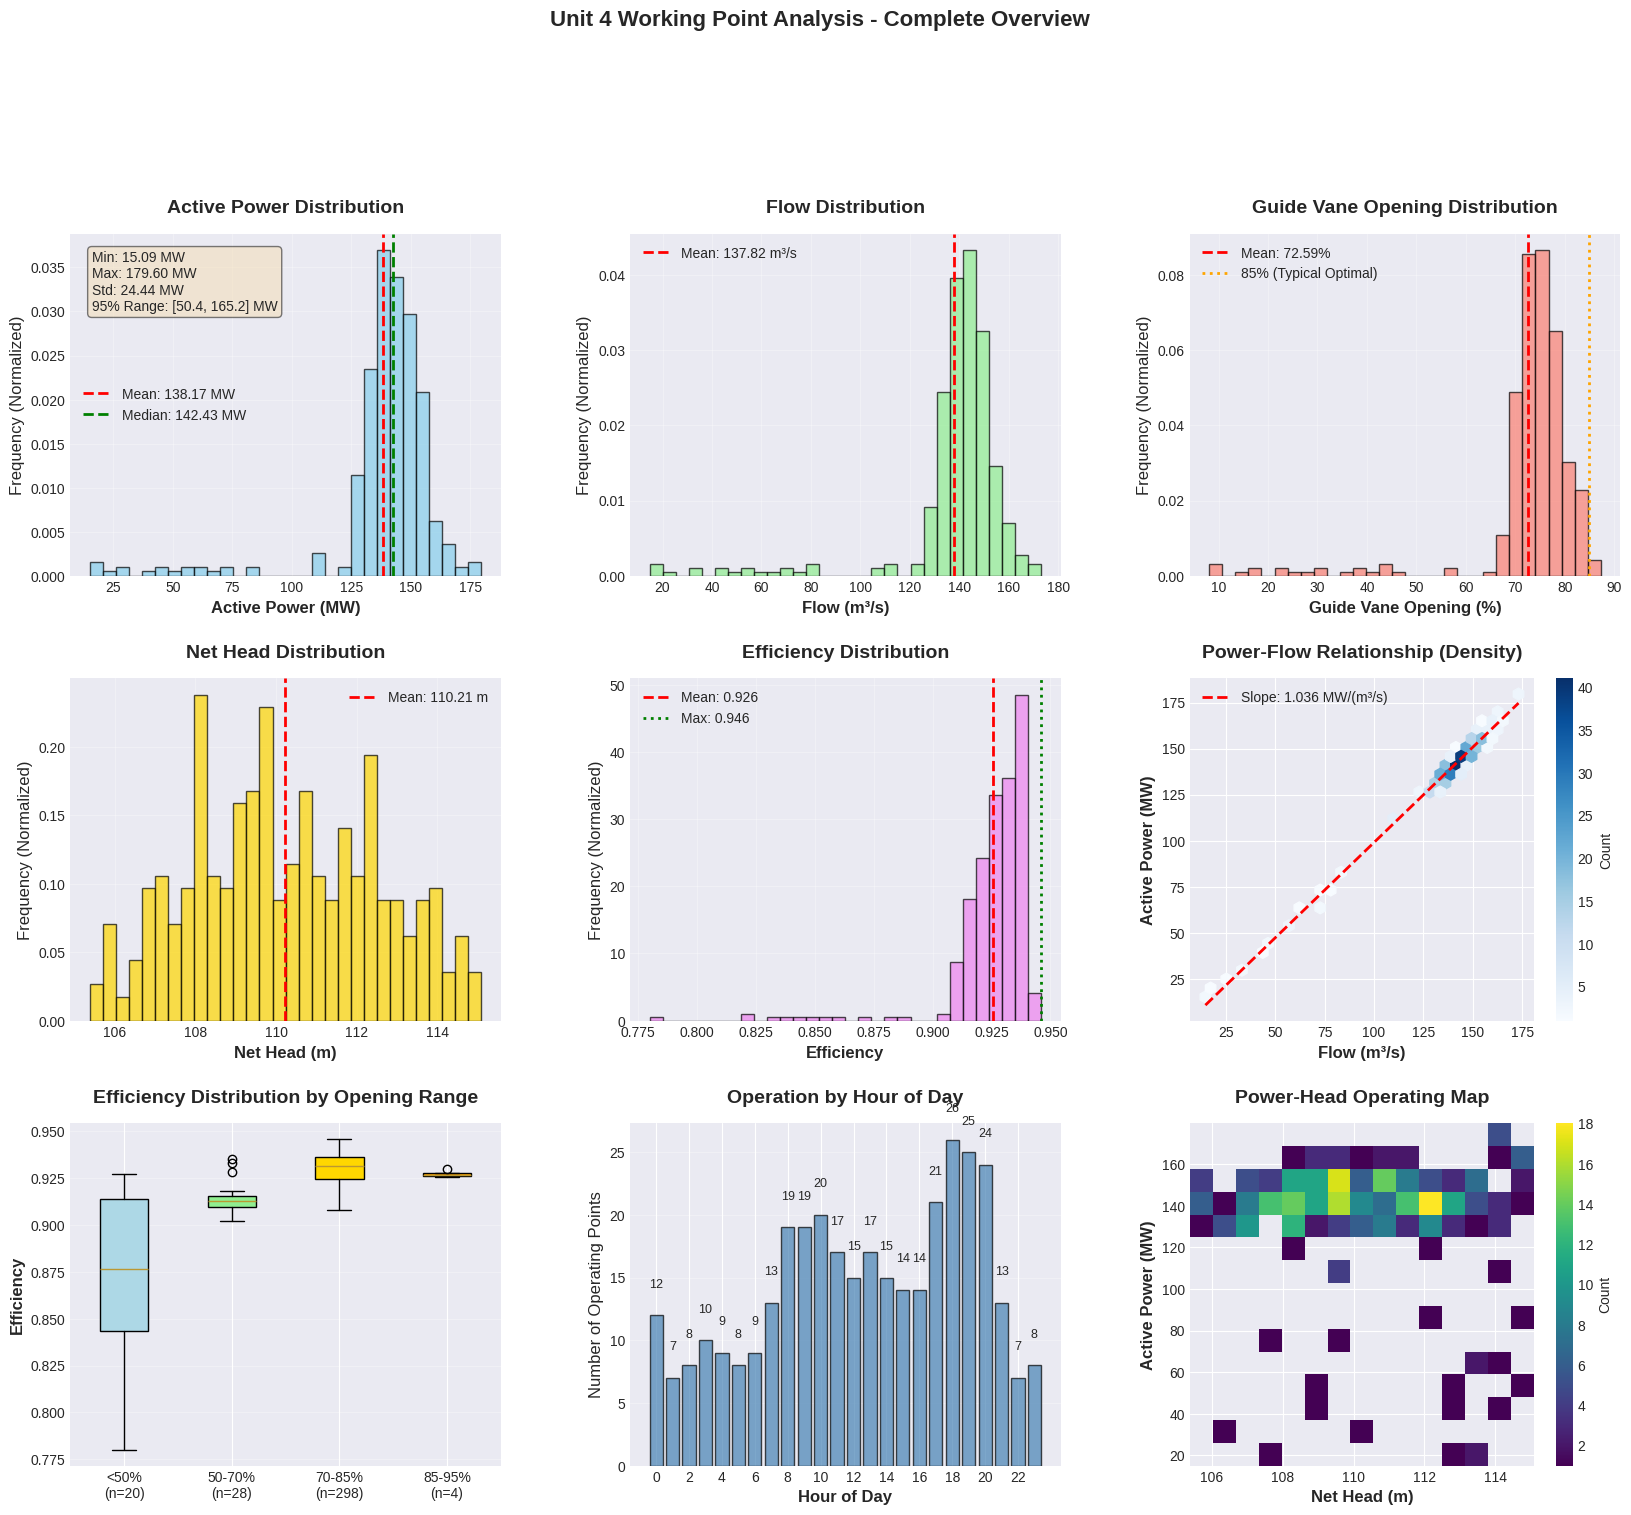

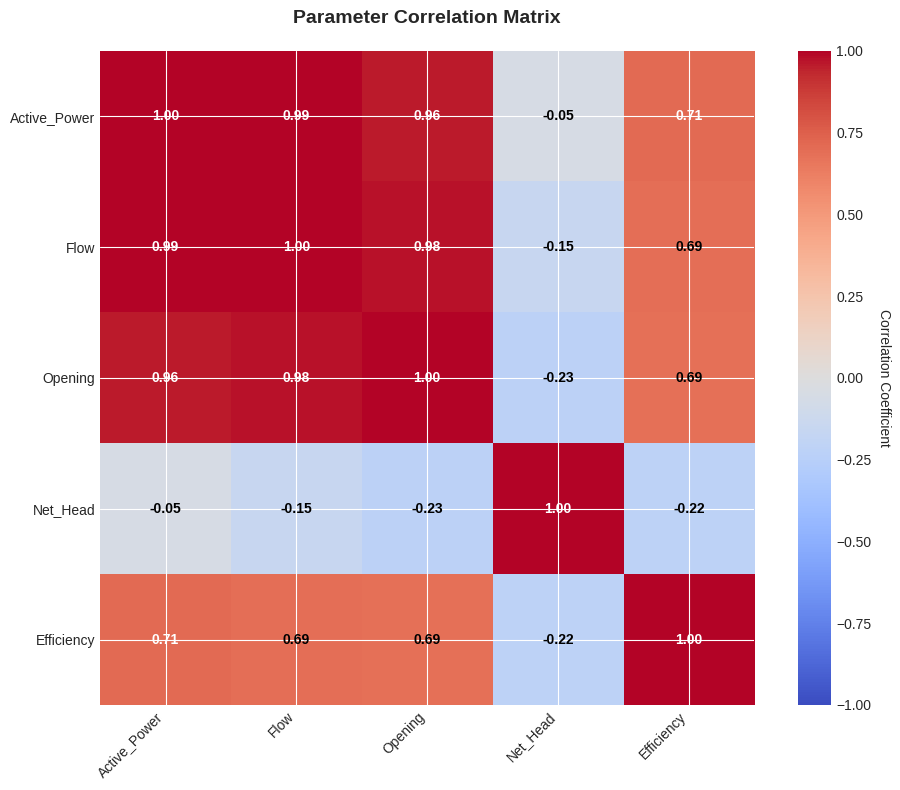

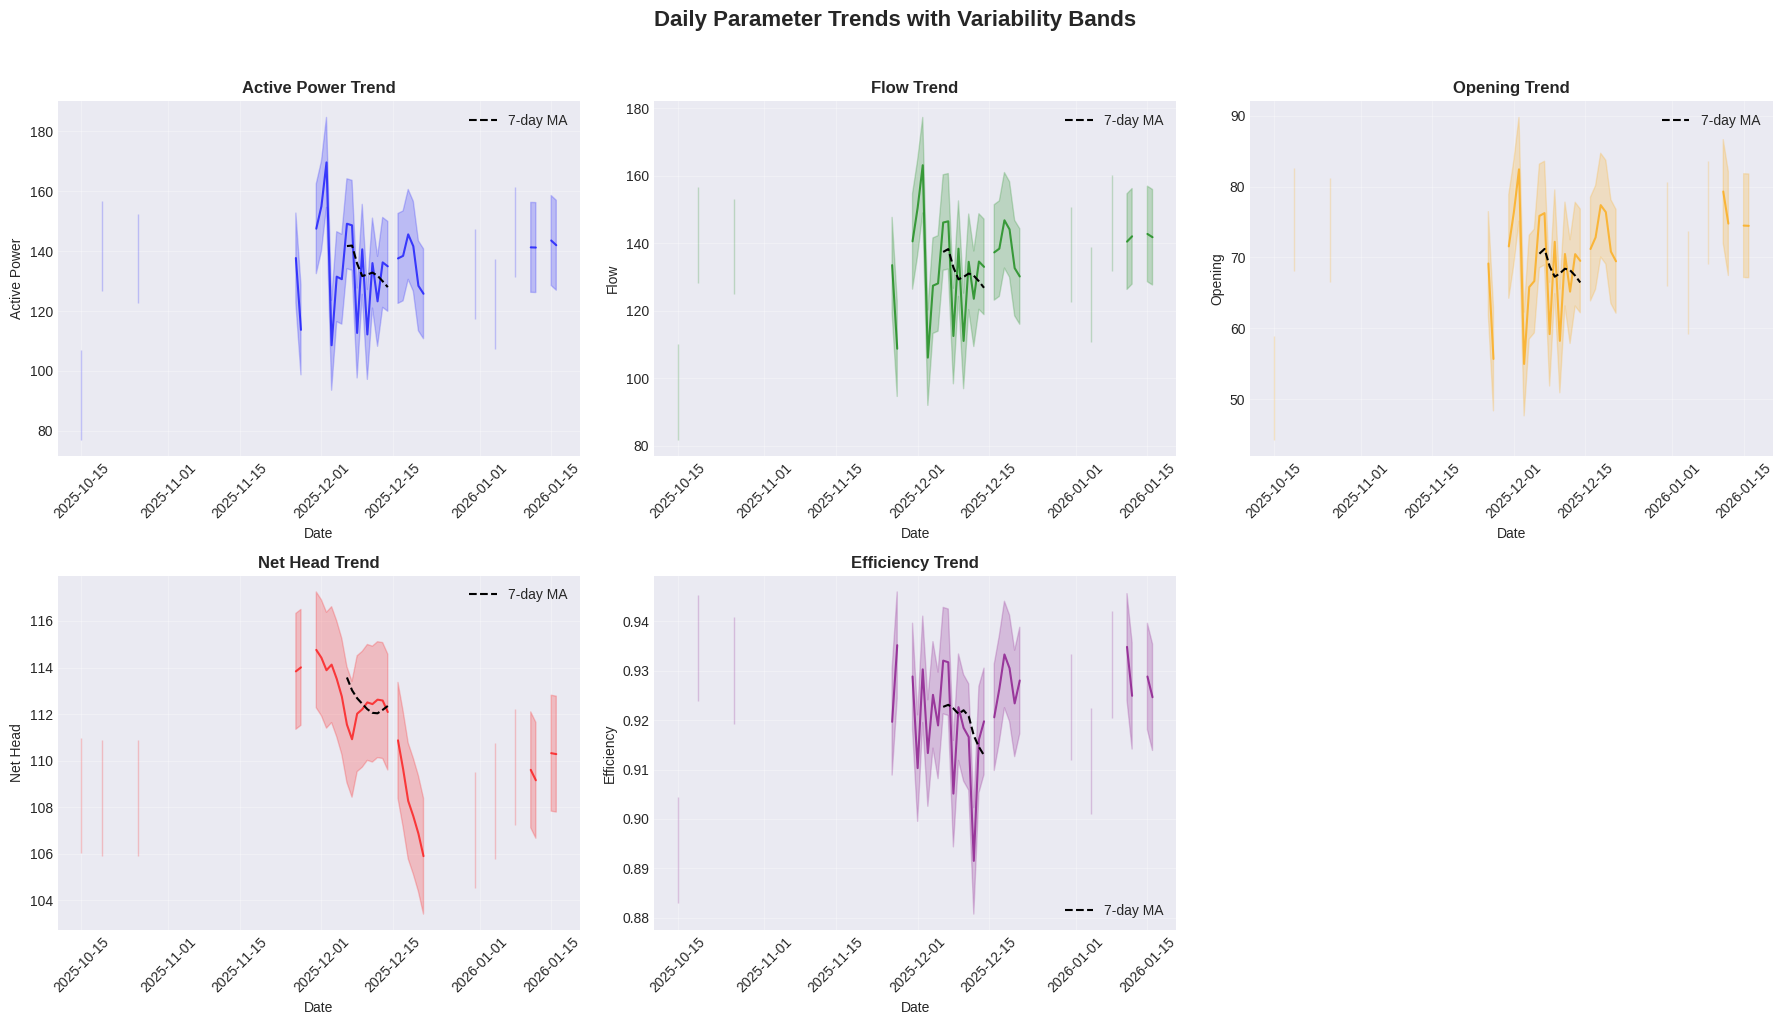

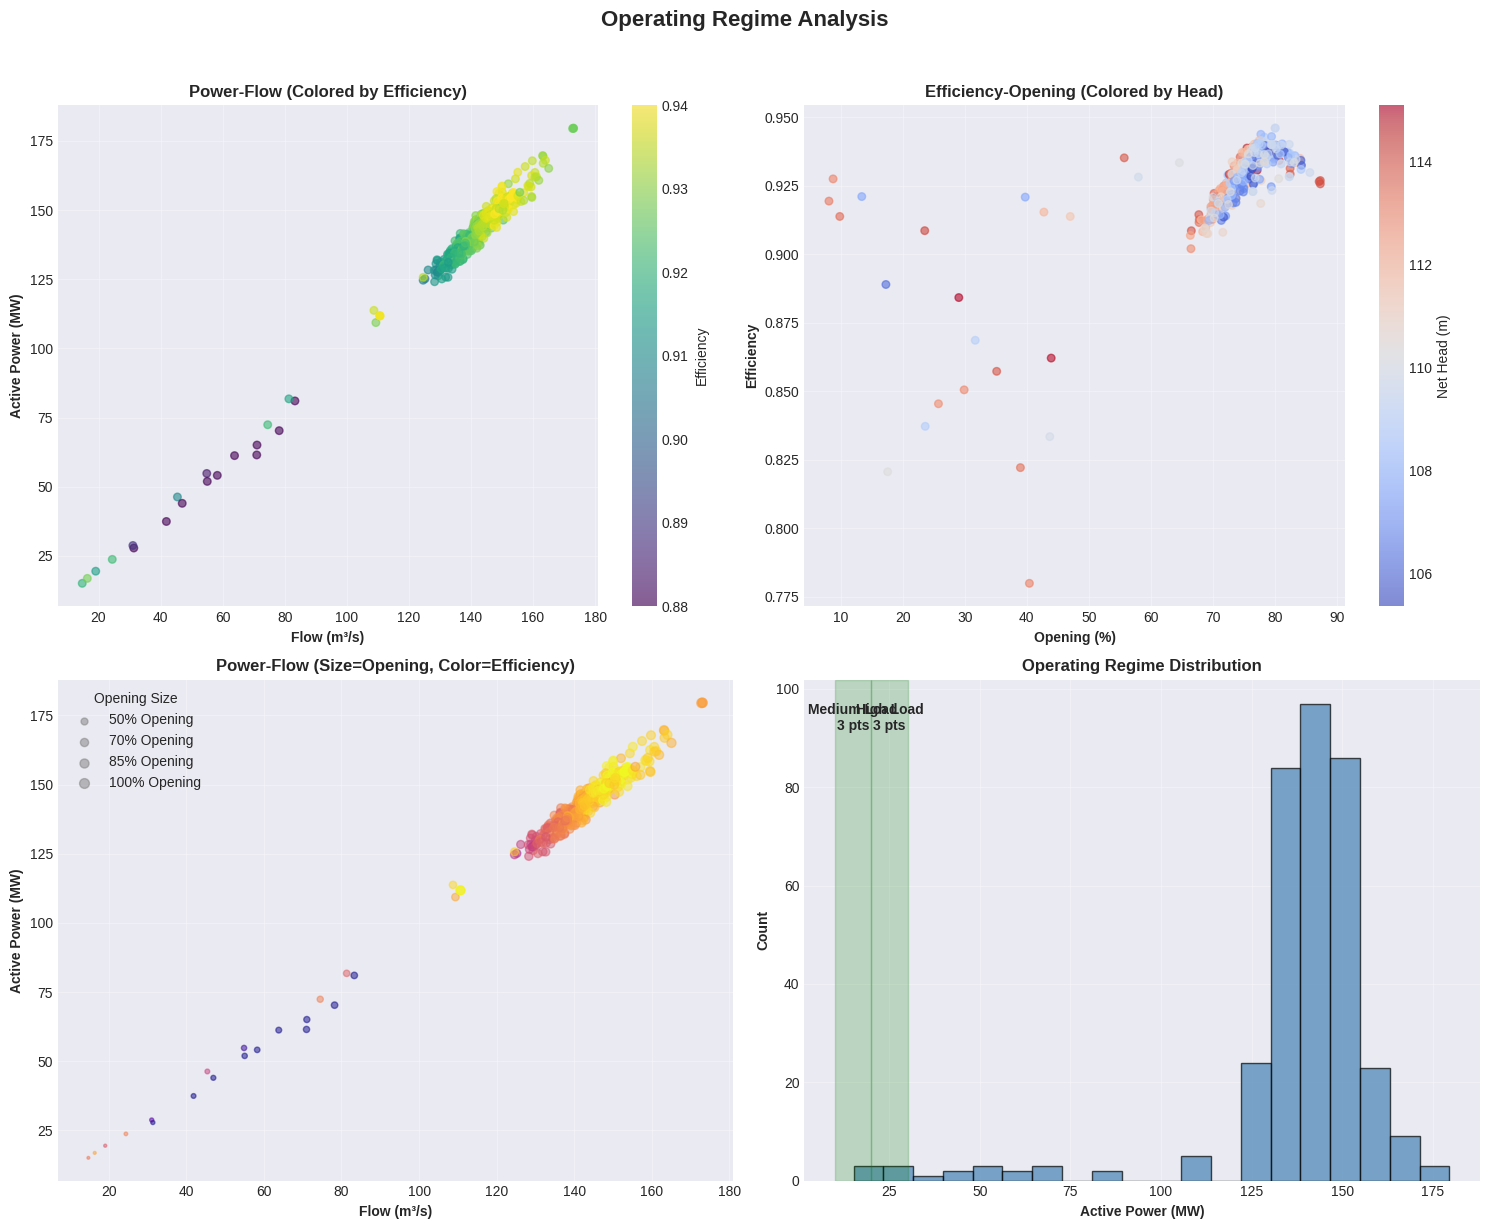


Detailed Statistics:
              count     mean     std      min      25%      50%      75%  \
Active_Power  350.0  138.166  24.402   15.086  135.206  142.434  149.070   
Flow          350.0  137.824  23.377   14.755  136.121  141.923  148.145   
Opening       350.0   72.593  11.977    8.131   71.969   74.898   77.690   
Net_Head      350.0  110.214   2.314  105.376  108.305  109.951  112.127   
Efficiency    350.0    0.926   0.018    0.780    0.921    0.929    0.936   

                  max     cv  
Active_Power  179.602  0.177  
Flow          173.072  0.170  
Opening        87.288  0.165  
Net_Head      115.099  0.021  
Efficiency      0.946  0.020  


In [12]:
# The WorkingPointAnalyzer class is defined in Cell AVx5Oy6Sun5g.
import matplotlib.pyplot as plt

# Instantiate the analyzer with the correct file path
analyzer = WorkingPointAnalyzer(CSV_FILE_PATH)

print("Loading and preprocessing data...")
df_operational = analyzer.load_and_preprocess()

print("\nCalculating statistics...")
stats_df, corr_matrix = analyzer.calculate_statistics()

print("\n" + "="*60)
print("Generating visualizations...")
print("="*60)

# Create all visualizations
print("1. Creating comprehensive histograms...")
fig1 = analyzer.plot_comprehensive_histograms()

print("2. Creating correlation heatmap...")
fig2 = analyzer.plot_correlation_heatmap()

print("3. Creating time series distributions...")
fig3 = analyzer.plot_time_series_distributions()

print("4. Creating operating regime scatter plots...")
fig4 = analyzer.plot_operating_regime_scatter()

# Generate summary report
print("\nGenerating summary report...")
report = analyzer.generate_summary_report()

# Print report to console
print(report)

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)

# Show plots
plt.show()

# Optional: Print detailed statistics dataframe
print("\nDetailed Statistics:")
print(stats_df.round(3))